In [1]:
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping, Callback, ModelCheckpoint
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel
from darts import TimeSeries, concatenate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from darts.metrics import mae, mse, mape
from darts.utils.statistics import check_seasonality, plot_acf, extract_trend_and_seasonality,plot_hist, plot_residuals_analysis, plot_pacf, remove_seasonality
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import GaussianLikelihood
from darts.logging import get_logger, raise_log, raise_if_not
from darts.utils.utils import _build_tqdm_iterator
from darts.utils.data.inference_dataset import InferenceDataset

In [41]:
df = pd.read_csv('../DataSet/EDvisitfileLinkou.csv', encoding='ISO-8859-1')
 #确保'date'列是DateTime类型
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
all_series = TimeSeries.from_dataframe(df, value_cols='No' )

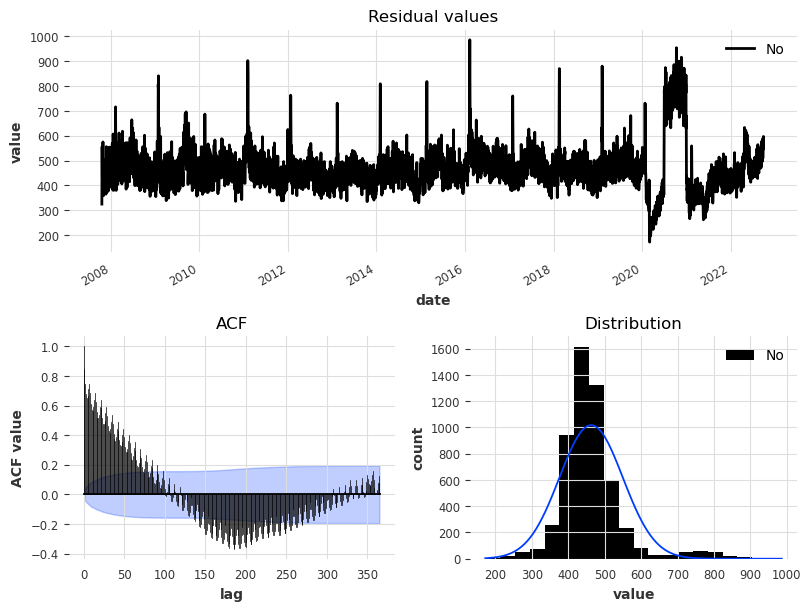

In [43]:
plot_residuals_analysis(all_series, acf_max_lag=365)

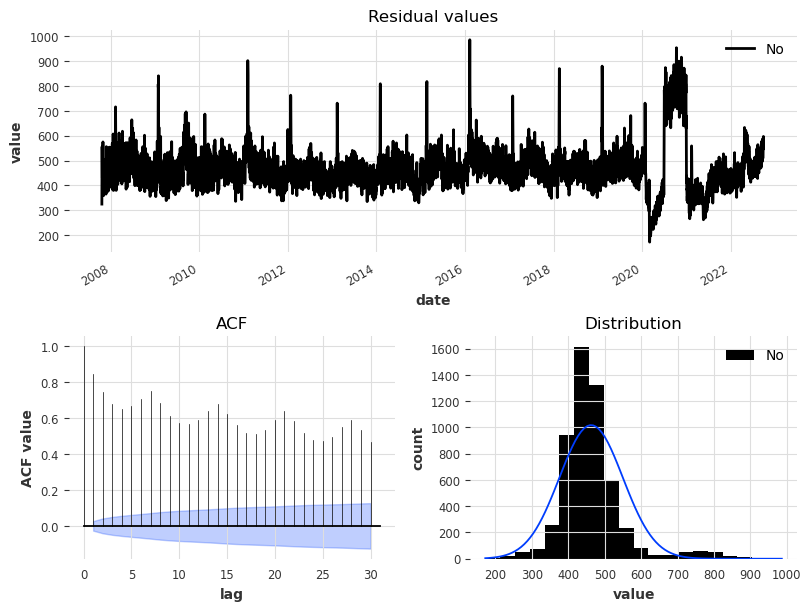

In [44]:
plot_residuals_analysis(all_series, acf_max_lag=30)

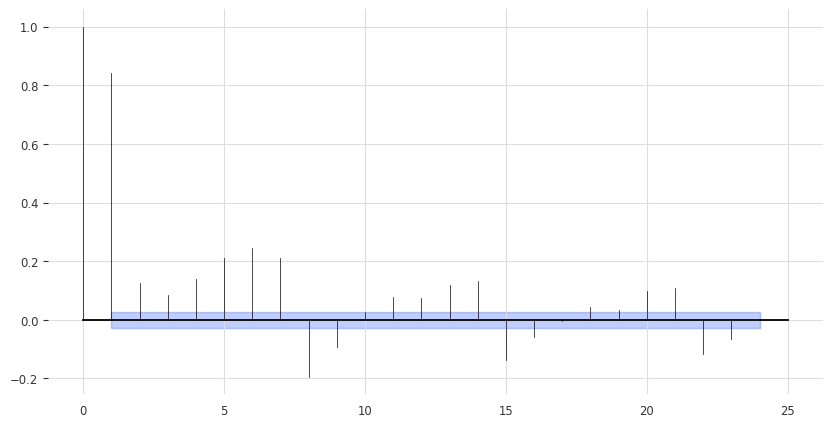

In [45]:
plot_pacf(all_series)

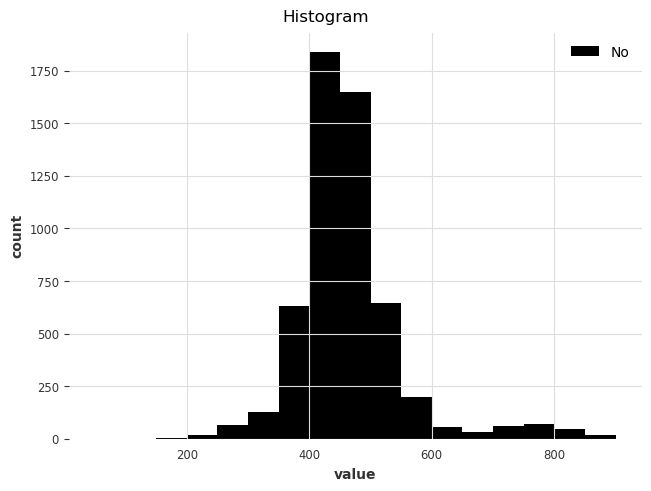

In [46]:
plot_hist(all_series, bins=[50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900])

In [47]:
check_seasonality(all_series, max_lag=365)

(True, 7)

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
no_linkou_dtype = df['No'].dtype

In [51]:
correlation_matrix = df.corr()

# Filter out the correlations with 'No_Linkou'
no_linkou_correlation = correlation_matrix['No'].sort_values(ascending=False)

no_linkou_correlation

No               1.000000
Outbreak         0.650071
NewYear          0.268141
Dayoff           0.255343
Sun              0.229705
Sep              0.109985
Year             0.073313
COVID19          0.057735
Jul              0.055182
Mon              0.052704
Aug              0.049219
Feb              0.046056
Oct              0.036040
Month            0.034974
Sat              0.029336
Dayscaled        0.002991
Day              0.002991
Jun             -0.002920
Jan             -0.004403
Nov             -0.029232
May             -0.041161
Fri             -0.054208
Dec             -0.057122
Tue             -0.059897
Apr             -0.062743
Wed             -0.089445
Mar             -0.096138
Thr             -0.108165
Level_3_Alert   -0.125699
Name: No, dtype: float64

C:\Users\ian11\AppData\Local\Temp\ipykernel_25812\3017709362.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=filtered_correlations_excluded.values, y=filtered_correlations_excluded.index, palette='magma')


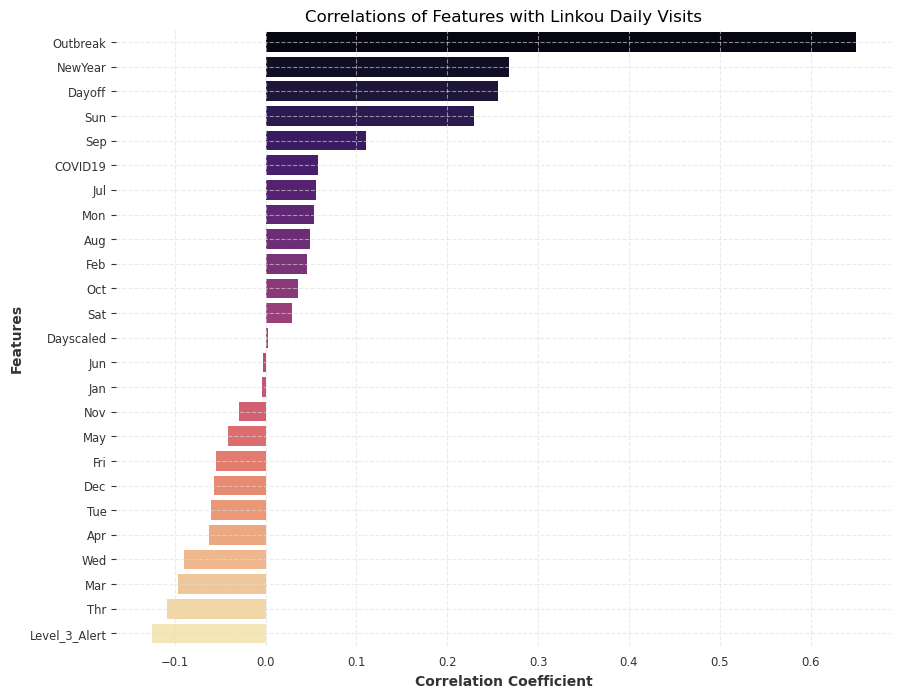

In [65]:
features_to_exclude = [
    "Year", "Month", "Day","No"]

filtered_correlations_excluded = no_linkou_correlation.drop(index=features_to_exclude)

# Plotting the remaining features after further exclusion
plt.figure(figsize=(10, 8))
sns.barplot(x=filtered_correlations_excluded.values, y=filtered_correlations_excluded.index, palette='magma')
plt.title('Correlations of Features with Linkou Daily Visits')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

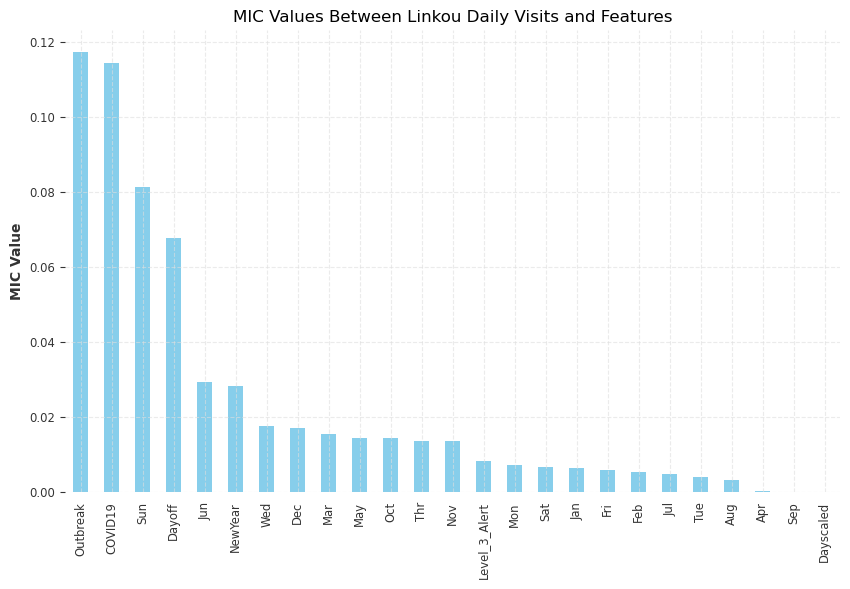

In [67]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

# Prepare the data for MIC calculation
features = filtered_correlations_excluded.index.tolist() + ['No']
data_mic = df[features].dropna()  # Drop any missing values to prepare for MIC calculation

# Compute MIC values
mic_values = mutual_info_regression(data_mic.drop('No', axis=1), data_mic['No'])

# Create a series for easier plotting
mic_series = pd.Series(mic_values, index=data_mic.drop('No', axis=1).columns)

# Plotting the MIC values
plt.figure(figsize=(10, 6))
mic_series.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('MIC Values Between Linkou Daily Visits and Features')
plt.ylabel('MIC Value')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

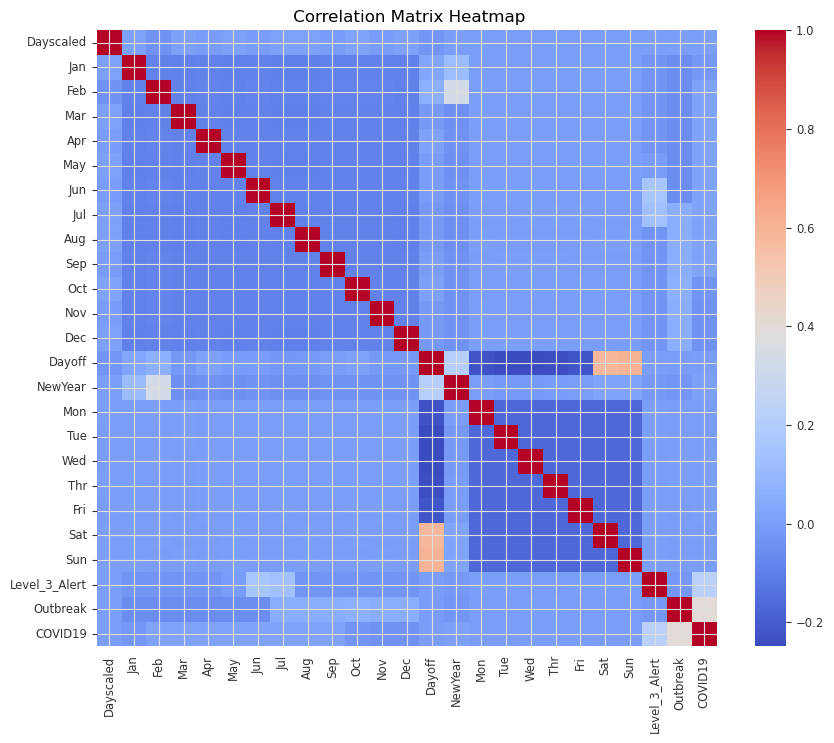

In [79]:
import seaborn as sns

heatmap_data = correlation_matrix

'''
features_to_exclude = [
    "Year", "Month", "Day", 
    "ConfirmedCases", "COV19Thread", 
]
'''
heatmap_data_excluded = heatmap_data.drop(
    labels=features_to_exclude, 
    axis=0  # Remove from rows
).drop(
    labels=features_to_exclude, 
    axis=1  # Remove from columns
)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data_excluded, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title(' Correlation Matrix Heatmap')
plt.show()

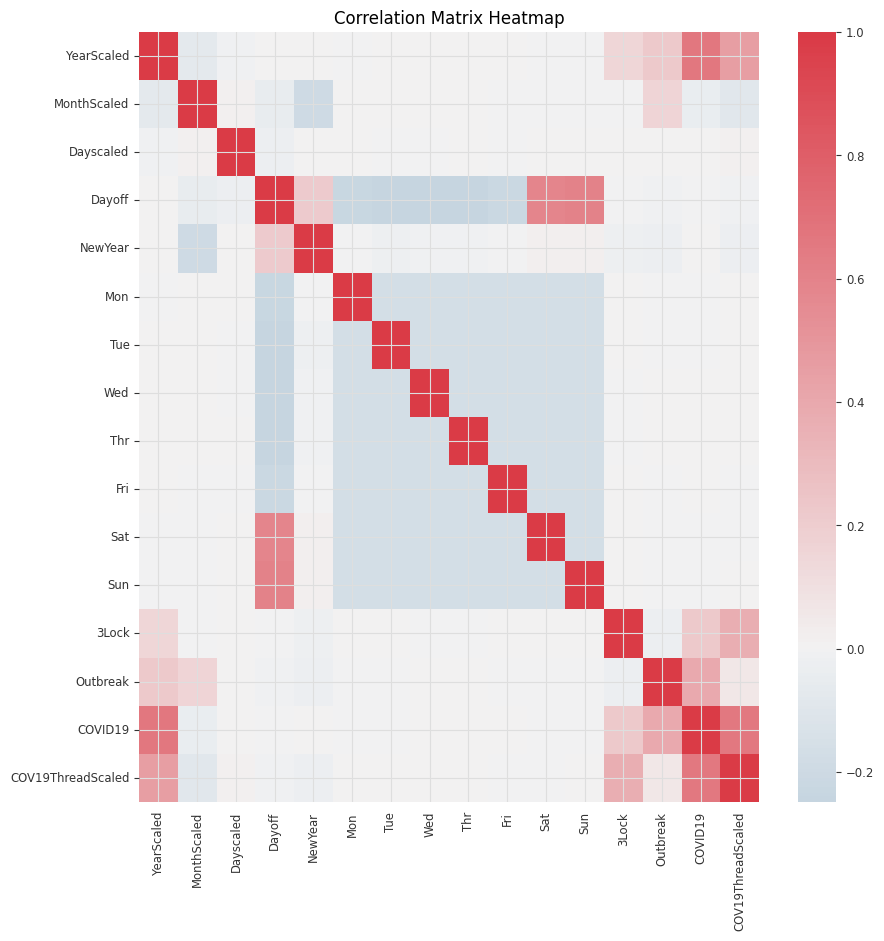

In [16]:


# Exclude the specified features
heatmap_data_excluded = correlation_matrix.drop(
    labels=features_to_exclude, 
    axis=0  # Remove from rows
).drop(
    labels=features_to_exclude, 
    axis=1  # Remove from columns
)

# Plotting the heatmap with the specified color scheme
plt.figure(figsize=(10, 10))
sns.heatmap(
    heatmap_data_excluded, 
    annot=False, 
    fmt=".2f", 
    cmap=sns.diverging_palette(240, 10, as_cmap=True), 
    center=0,  # Center the colormap at zero
    cbar=True
)
plt.title('Correlation Matrix Heatmap')
plt.show()